# Lab 7 - Infotaxis (aka- Curiosity)

Here we will explore how our little artificial organisms do two things:

1. Learn a *concept* of information as a signal. This reflects the curiosity about a signal, as opposed to its magnitude.
2. How this concept of information facilitates learning in noisy environments.

## Background

In this lab we return to _taxic explorations_. Recall that in Lab 4 (evidence accumulation) we look at what happens when sense information is not just noisy, but partially observed. In otherwords, when there is distortion in the channel of information.

Here we will compare the simple chemotaxic framework, where agents simply follow the gradient of the scent, to an _infotaxic_ framework where agents follow the _information_ carried in the signal instead.



Recall that our basic model of valentino exploration is as simple as can be.

- When the gradient is positive, meaning you are going "up" the gradient, the probability of turning is set to _p pos_.
- When the gradient is negative, the turning probability is set to _p neg_. (See code below, for an example).
- If the agent "decides" to turn, the direction it takes is uniform random.
- The length of travel before the next turn decision is sampled from an exponential distribution just like the _DiffusionDiscrete_

### Information agents
We will study three agents. One who does _chemotaxis_. One who does a kind of _infotaxis_. One that does random search (aka Diffusion). For fun, let's call this one a _randotaxis_ agent. This last rando-agent is really a control. A reference point.

In a sense the _chemotaxis_ agent only tries to answer question Q2 (above). While _infotaxis_ only tries to answer Q1. They are extreme strategies, in other words. The bigger question we will ask, in a very limited setting, is which extreme method is better _generally_?


### Costly cognition
Both _chemo-_ and _infotaxis_ agents will use a simple accumulation-of-evidence process to try and make better decisions about the direction of the gradient. These decisions are of course statistical in nature.

Our control agent, _randotaxis_, will be another simple Brownian random walk agent.


## Reviewing the definition of _chemotaxis_:
Our _chemotaxis_ agent (_AccumulatorGradientGrid_) tries to directly estimate the gradient $\nabla$ in scent by comparing the level of scent at the last grid position it occupied to the current scent level ($o$). By last grid position here we mean the last grid position when it moved last.

$$\nabla \approx o_t - o_{t-1}$$

Because an accumulator is present, our chemo- sequentially tries to estimate this gradient by sampling the new current location, until the threshold is met.

 Chemo-accumulators have what we can think of as two cognitive or behavioral steps:

1. Use an accumulator to (stabely) estimate the chemo gradient
2. Use the gradient to make turning decisions

## A definition of _infotaxis_:
Compared to chemo- definition the definition of infotaxis is a little more involved. It has what we can think of as five cognitive or behavioral steps:

1. Use an accumulator to (stabely) estimate if there is a scent or not. AKA hits and misses.
2. Build a probability model of hits/misses (at every point)
3. Measure information gained when probability model changes. This is quantified using the KL divergence that measures how the properties of the signal are changing.
4. Measure the gradient of information gains
5. Use the gradient to make turning decisions

_Note_: Even though the info-accumulator is more complex, it can take advantage of missing scent information to drive its behavior. It can also use positive scent hits, of course, too.

If you want to look at exactly how this agent works, check out line 1242 in the _agents.py_ file: /usr/local/lib/python3.7/dist-packages/explorationlib/agent.py

## Section 0 - Setup

First let's set things up for the two parts of the lab. You've done this before, so we don't need to specify each installation and module step.

In [1]:
# For local debuggging purposes
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# # Install files from Google Drive
!pip install --upgrade /content/drive/My\ Drive/Code/explorationlib

Mounted at /content/drive
Processing ./drive/My Drive/Code/explorationlib
  Preparing metadata (setup.py) ... done
  Created wheel for explorationlib: filename=explorationlib-0.0.1-py3-none-any.whl size=42382 sha256=823c458fb8121ac638536a00b9d942c0f8ee708c599500ddb90aaa78e594bdcf
  Stored in directory: /tmp/pip-ephem-wheel-cache-0060o68t/wheels/70/04/31/d07fb84326fd8056827d857835a51893f17af60294640e06ad
Successfully built explorationlib


In [2]:
#!pip install --upgrade git+https://github.com/coaxlab/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-qlmatlf2
  Running command git clone --filter=blob:none --quiet https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-qlmatlf2
  Resolved https://github.com/MattChanTK/gym-maze.git to commit 83176811b49b5538a6213520612f44fb1bc49114
  Preparing metadata (setup.py) ... done
  Created wheel for gym_maze: filename=gym_maze-0.4-py3-none-any.whl size=14219 sha256=13f81d189030e13c5707cfc9bd831cf6d59dd1c5a405aa0d0eee042870409389
  Stored in directory: /tmp/pip-ephem-wheel-cache-xs_t9cd1/wheels/b0/53/2e/e282706624110bc964538d7840bef68fef2bc1865a87e3016e
Successfully built gym_maze


In [3]:
import shutil
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

import explorationlib
from explorationlib.local_gym import ScentGrid

from explorationlib.agent import DiffusionGrid
from explorationlib.agent import AccumulatorGradientGrid
from explorationlib.agent import AccumulatorInfoGrid

from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import add_noise
from explorationlib.local_gym import create_grid_scent_patches

from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid
from explorationlib.plot import plot_targets2d

from explorationlib.score import total_reward
from explorationlib.score import num_death

In [4]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

## Section 1 - Chemotaxis vs. curiosity

In this section we take on accumulating evidence as a policy for decision making. Our venue is still chemotaxis, but now our sensors are noisy. The presence of this uncertainty makes decisions--of the kind common to decision theory--a necessity.

Let's see just how helpful the concept of information for chemotaxic search can be.

In [5]:
# Noise and missing scents
p_scent = 0.5
noise_sigma = 1

# Shared
num_experiments = 100
num_steps = 500
seed_value = 5838

# ! (leave alone)
detection_radius = 1
max_steps = 1
min_length = 1
num_targets = 50
target_boundary = (10, 10)

# Targets
prng = np.random.RandomState(seed_value)
targets = uniform_targets(num_targets, target_boundary, prng=prng)
values = constant_values(targets, 1)

# Scents
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=1, sigma=2)
    scents.append(scent)

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

Again we are working a scent grid environment where each target emits noisy chemical signals (scents) according to our definitions above.

Here's an example of our environment

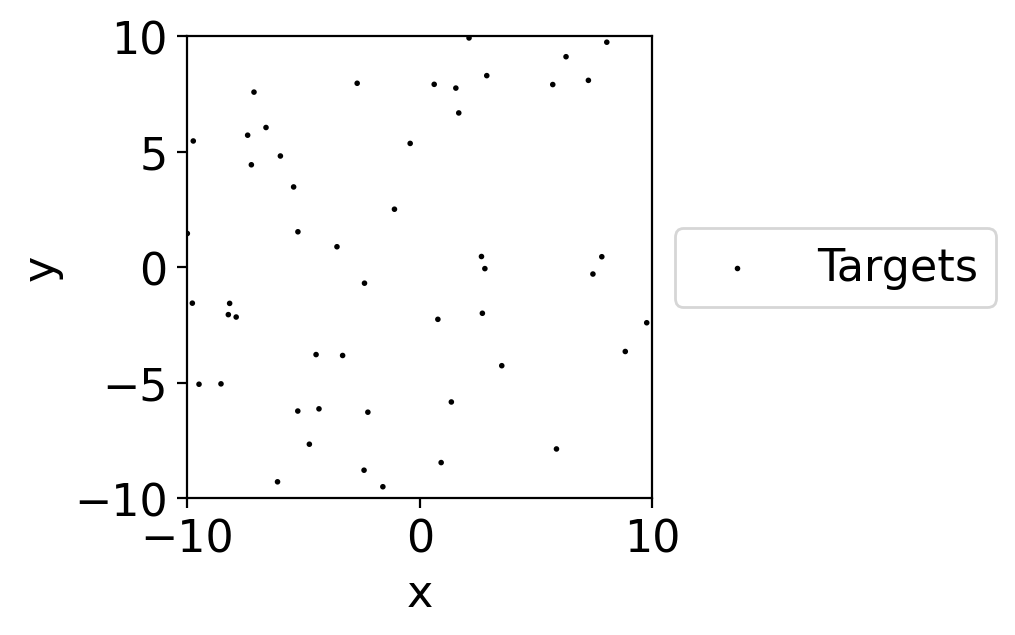

In [6]:
plot_boundary = (10, 10)
num_experiment = 0
ax = None
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

We will use 3 agents in these sims:

- Rando: Uses random Brownian motion search.
- Chemo: Uses only the detected scent gradient to make a decision.
- Info: Estimates how much *information* is encoded in the scent signal to make a decision.

In [7]:
# Agents

# Random search agent
diff = DiffusionGrid(min_length=min_length)
diff.seed(seed_value)

drift_rate = 3
threshold = 2

# Chemotaxis agent
chemo = AccumulatorGradientGrid(
    min_length=min_length,
    max_steps=max_steps,
    drift_rate=drift_rate,
    threshold=threshold,
    accumulate_sigma=1
)
chemo.seed(seed_value)


# Infotaxis agent
info = AccumulatorInfoGrid(
    min_length=min_length,
    max_steps=max_steps,
    drift_rate=drift_rate,
    threshold=threshold,
    accumulate_sigma=1
)
info.seed(seed_value)



[5838]

Now let's run the experiments.

In [34]:
exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps,
    num_experiments=2,
    dump=False,
    split_state=True,
    seed=seed_value
)


info:   0%|          | 0/2 [00:00<?, ?it/s]

[autoreload of explorationlib.agent failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 276, in update_instances
    refs = gc.get_referrers(old)
KeyboardInterrupt
]


4

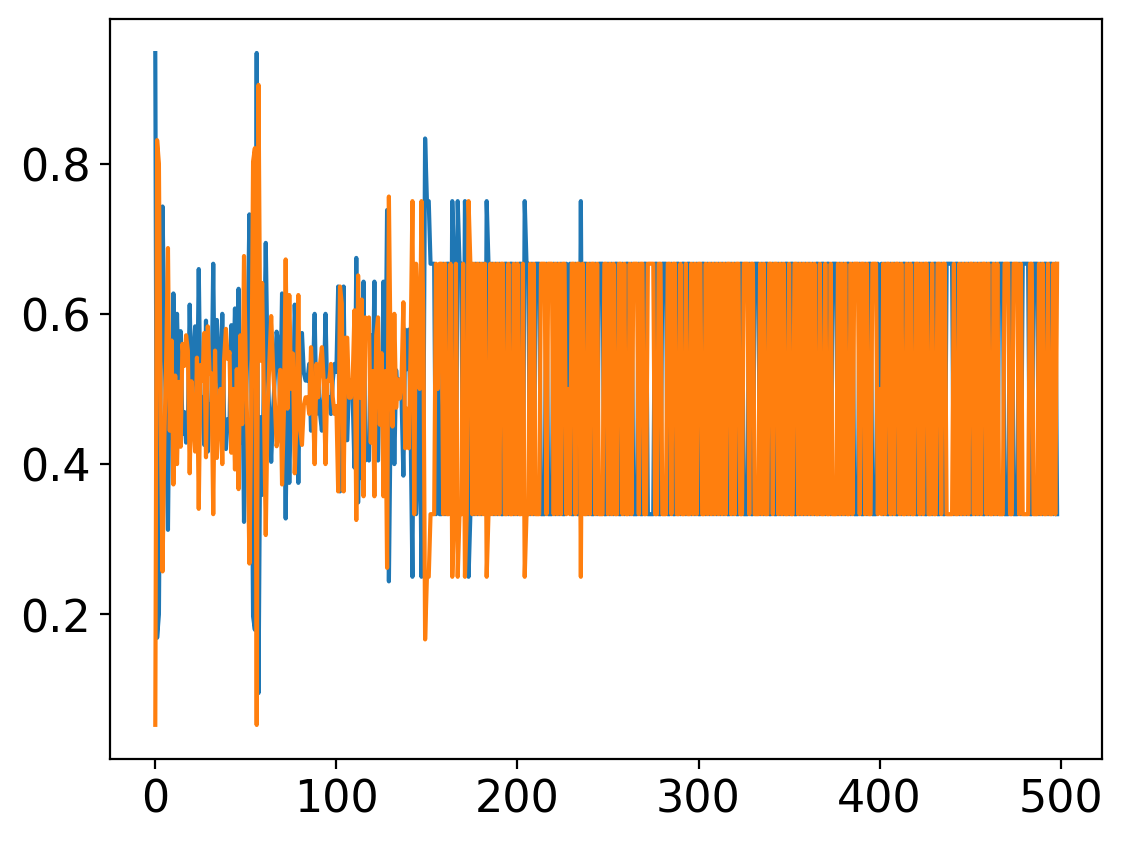

In [39]:
# x = exp[1]["agent_info_gain"]
# y = exp[1]["agent_evidence"]
# #fig = plt.scatter(x,y)
x = exp[1]["agent_p_new"]
plt.plot(x)
# #exp[1]["agent_pos"][-1]
np.sum(exp[1]["agent_stop"])

In [41]:
exp[1]["agent_p_old"][-1]

[0.5, 0.5]

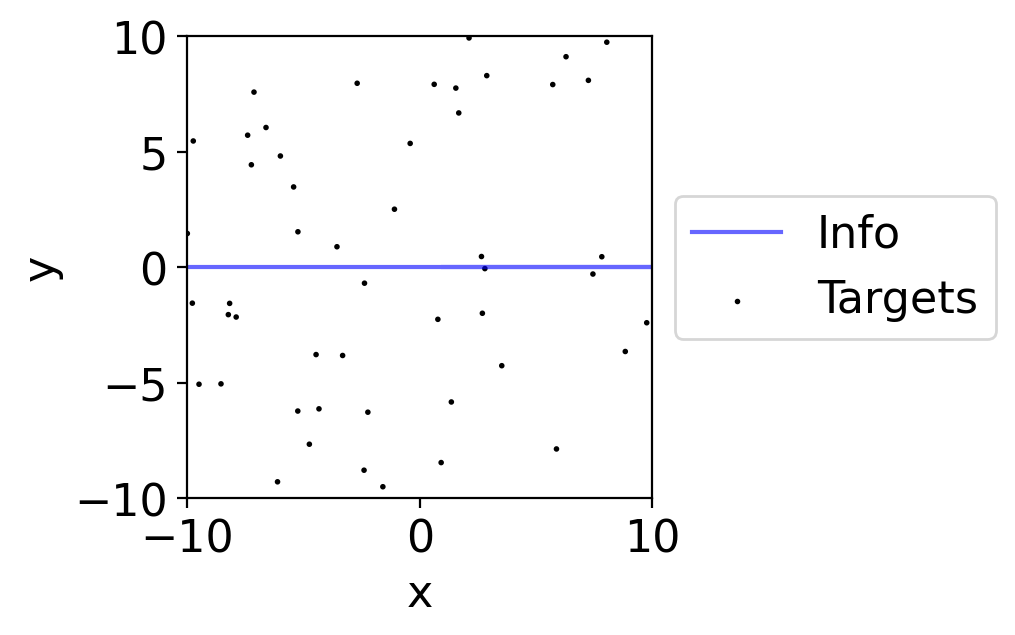

In [38]:
plot_boundary = (10, 10)

# -
num_experiment = 1
ax = None
ax = plot_position2d(
    select_exp(exp, num_experiment),
    boundary=plot_boundary,
    label="Info",
    color="blue",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

In [12]:
# Experiments
rand_exp = experiment(
    f"rand",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
chemo_exp = experiment(
    f"chemo",
    chemo,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
info_exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

rand:   0%|          | 0/100 [00:00<?, ?it/s]

chemo:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

Let's plot an example experiment. Here I'm choosing the second run for each agent.

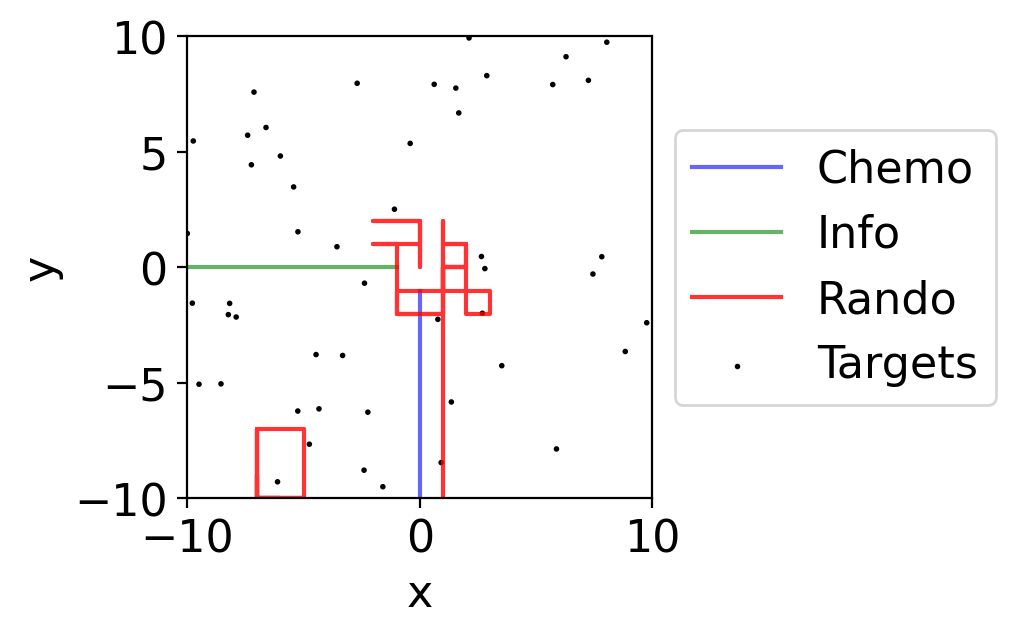

In [13]:
plot_boundary = (10, 10)

# -
num_experiment = 2
ax = None
ax = plot_position2d(
    select_exp(chemo_exp, num_experiment),
    boundary=plot_boundary,
    label="Chemo",
    color="blue",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(info_exp, num_experiment),
    boundary=plot_boundary,
    label="Info",
    color="green",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(rand_exp, num_experiment),
    boundary=plot_boundary,
    label="Rando",
    color="red",
    alpha=0.8,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

Hard to distinguish their individual behaviors, but our agents seem to be exploring.

Now let's evaluate some metrics of performance.

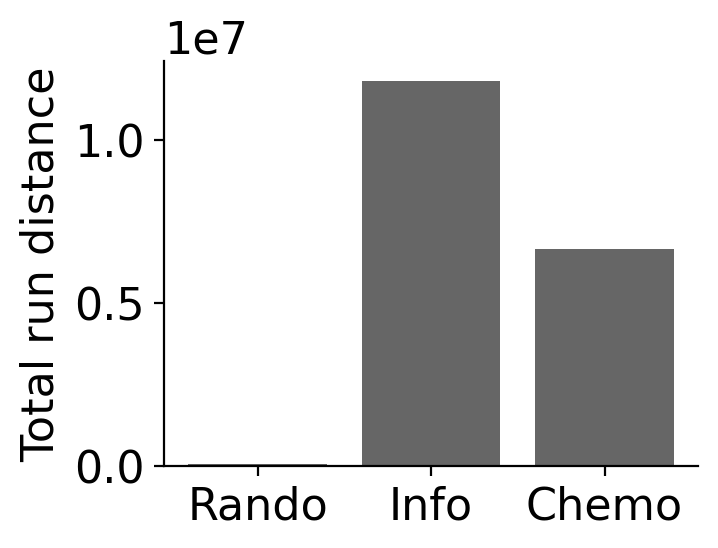

In [14]:
# Results
results = [rand_exp, info_exp, chemo_exp]
names = ["Rando", "Info", "Chemo"]
colors = ["red", "green", "blue"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    l = 0.0
    for r in res:
        l += np.sum(r["agent_num_step"])
    scores.append(l)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total run distance")
plt.tight_layout()
sns.despine()

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

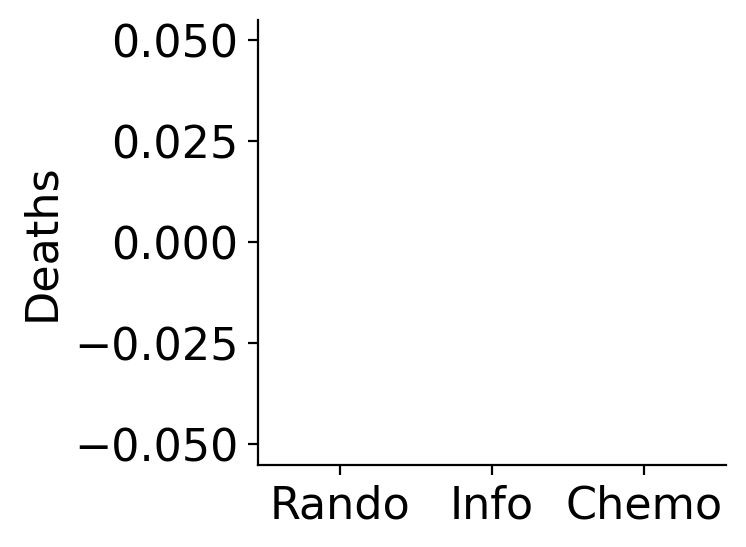

In [15]:
# Results
results = [rand_exp, info_exp, chemo_exp]
names = ["Rando", "Info", "Chemo"]
colors = ["red", "green", "blue"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

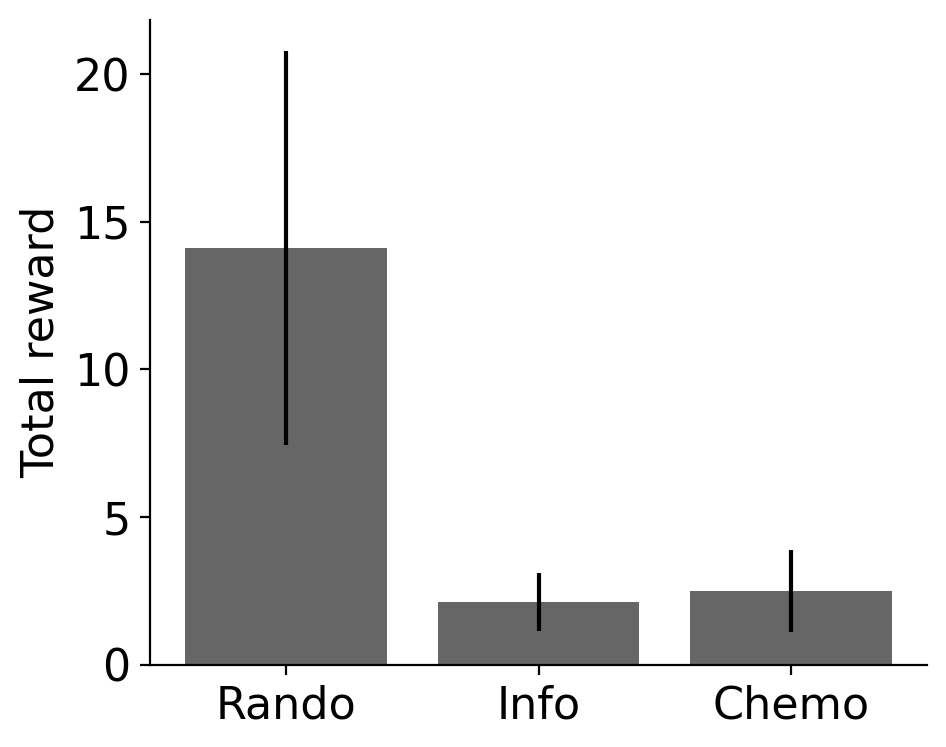

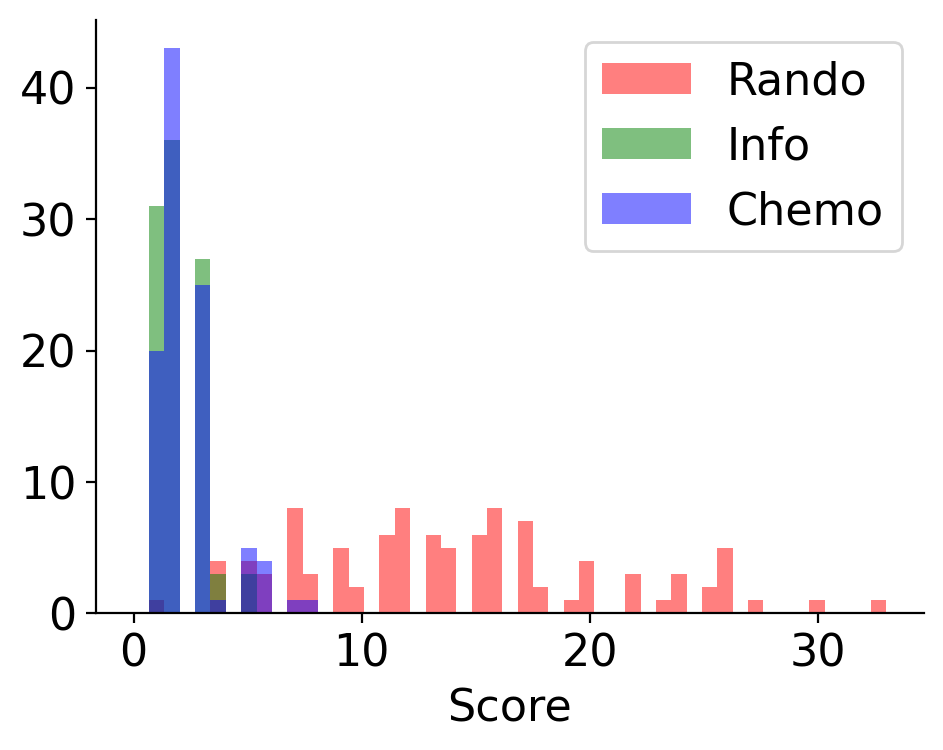

In [16]:
# Results
results = [rand_exp, info_exp, chemo_exp]
names = ["Rando", "Info", "Chemo"]
colors = ["red", "green", "blue"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

### Question 1.1

How does each of our agents perform across the performance measures we have chosen?

In [17]:
# Write your answer here as a comment. Explain yourself.

### Question 1.2

Is having a concept of information (i.e., the Info agent)helpful in these sorts of noisy environments? Why or why not based on how the agents performed? Compare to both Rando and Chemo.

In [18]:
# Write your answer here as a comment. Explain yourself.

## Section 2 - Robustness of information searching

In this final section we will see how the distortion in the channel driven by missing information influences the efficiency of our Info agent.

Here we will test a range of *p_scent* values. Essentially we will be turning *down* the distortion as *p_scent* increases. For these experiments we will hold the *noise_sigma* constant at 1.

In [19]:
# Our parameters
p_scents = [0.05, 0.25, .50, .75, .95]

# For plotting
colors = ["darkgreen", "seagreen", "cadetblue", "steelblue", "mediumpurple"]
names = p_scents # list(range(5))

Let's run these experiments. All of the parameters for the agent and environment (aside from *p_scent*) are specified below.

In [20]:
# Define the accumulation parameters
drift_rate = 3
threshold = 2
accumulate_sigma = 1.0

# Define non-scent probability values
noise_sigma = 1
amplitude = 1
detection_radius = 1
max_steps = 1
min_length = 1
num_targets = 50
target_boundary = (10, 10)

# How many experiments to run
num_experiments = 50

# Infotaxis agent
info = AccumulatorInfoGrid(
    min_length=min_length,
    max_steps=max_steps,
    drift_rate=drift_rate,
    threshold=threshold,
    accumulate_sigma=1
)
info.seed(seed_value)

# Run
results = []

for i, p_scent in zip(names, p_scents):
  # Targets
  prng = np.random.RandomState(seed_value)
  targets = uniform_targets(num_targets, target_boundary, prng=prng)
  values = constant_values(targets, 1)

  # Scents
  scents = []
  for _ in range(len(targets)):
      coord, scent = create_grid_scent_patches(
          target_boundary, p=p_scent, amplitude=amplitude, sigma=noise_sigma)
      scents.append(scent)

  # Env
  env = ScentGrid(mode=None)
  env.seed(seed_value)
  env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

  exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
  )

  results.append(exp)


info:   0%|          | 0/50 [00:00<?, ?it/s]

info:   0%|          | 0/50 [00:00<?, ?it/s]

info:   0%|          | 0/50 [00:00<?, ?it/s]

info:   0%|          | 0/50 [00:00<?, ?it/s]

info:   0%|          | 0/50 [00:00<?, ?it/s]

Now let us take a look at the performance of our agent across runs.

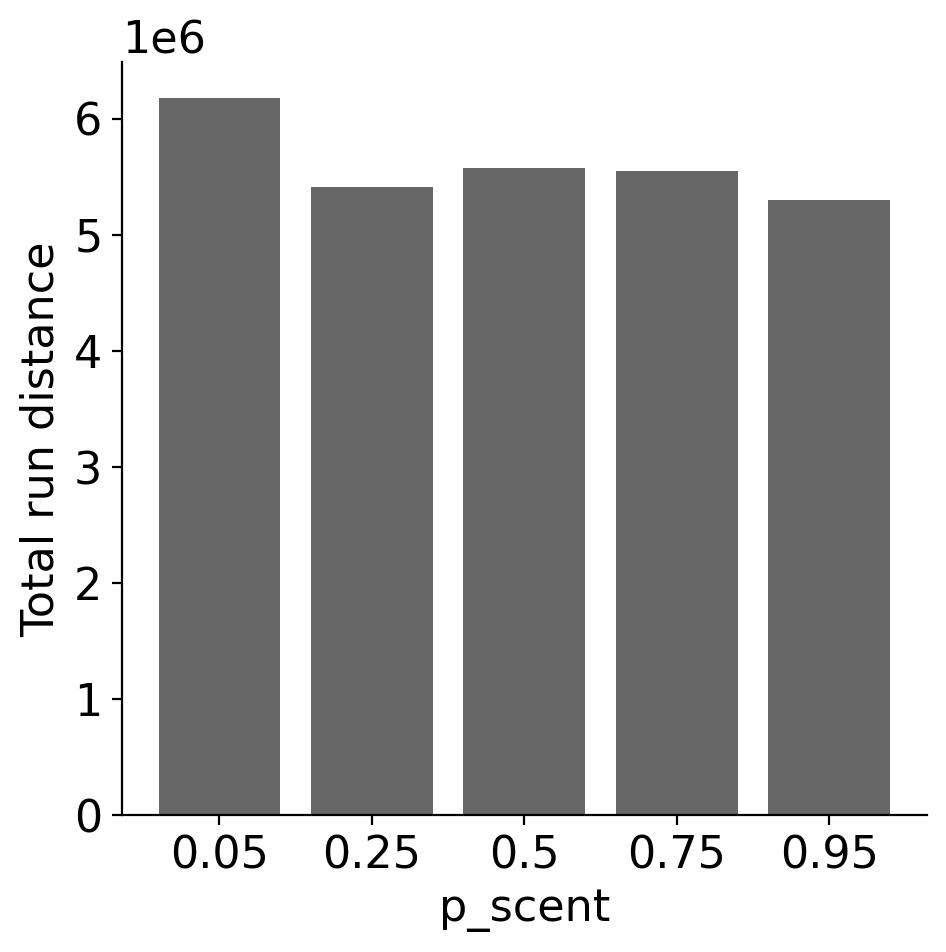

In [21]:
# Score
scores = []
for result in results:
    l = 0.0
    for r in result:
        l += np.sum(r["agent_num_step"])
    scores.append(l)

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Total run distance")
plt.xlabel("p_scent")
plt.tight_layout()
sns.despine()

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

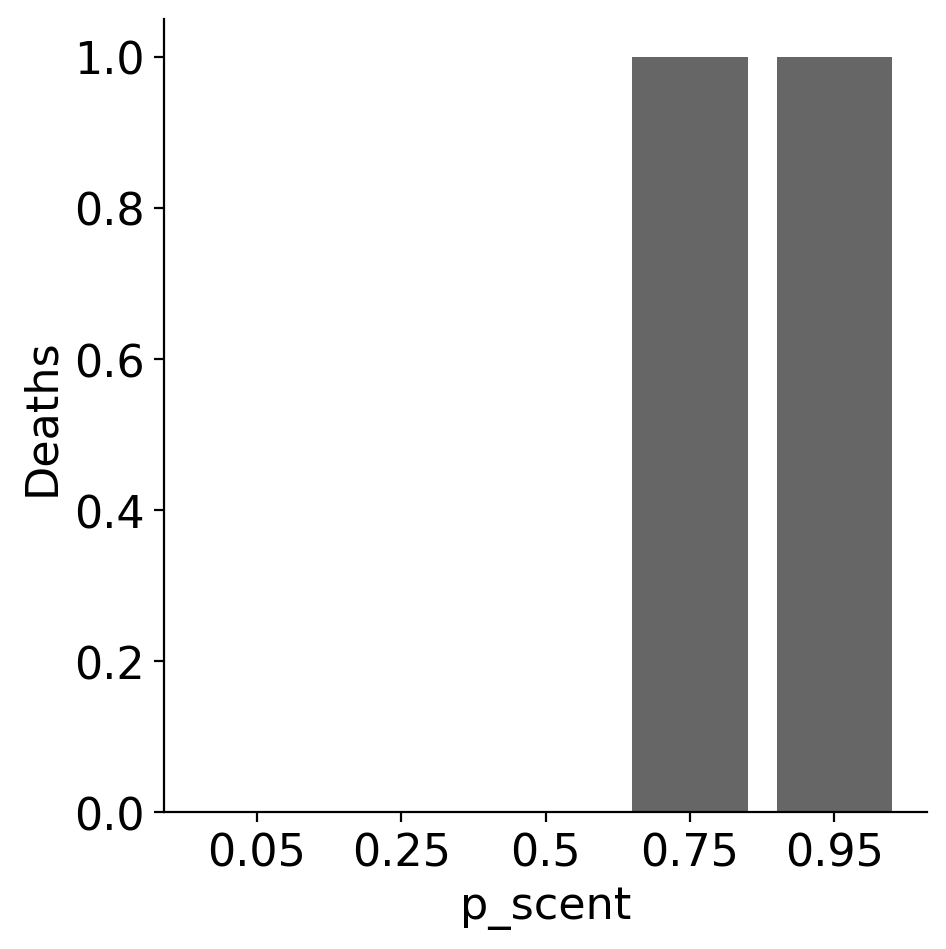

In [22]:
# Score
scores = []
for result in results:
    scores.append(num_death(result))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], scores, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.xlabel("p_scent")
plt.tight_layout()
sns.despine()

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

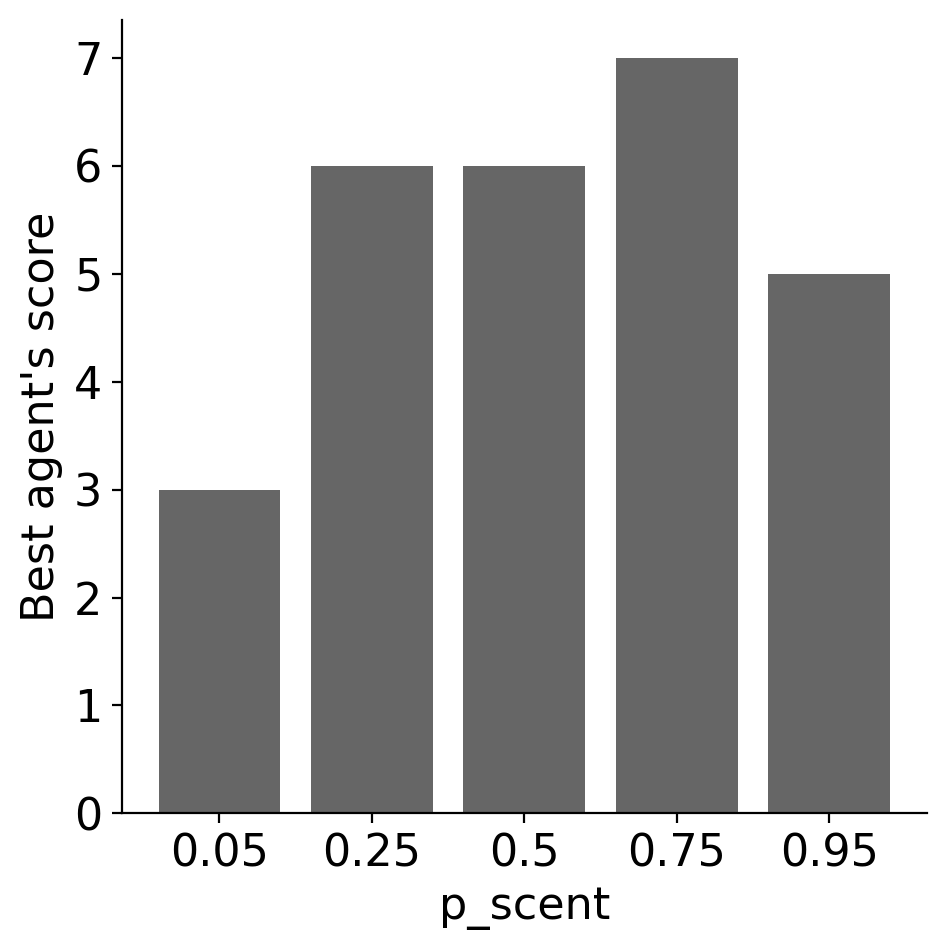

In [23]:
# Max Score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)

# Tabulate
m = []
for s in scores:
    m.append(np.max(s))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Best agent's score")
plt.xlabel("p_scent")
plt.tight_layout()
sns.despine()

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

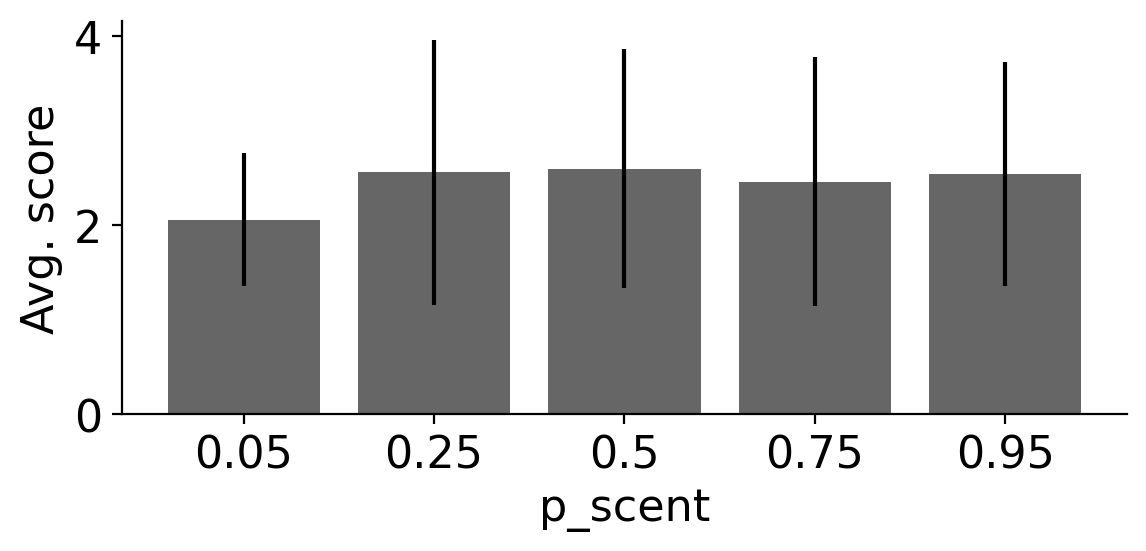

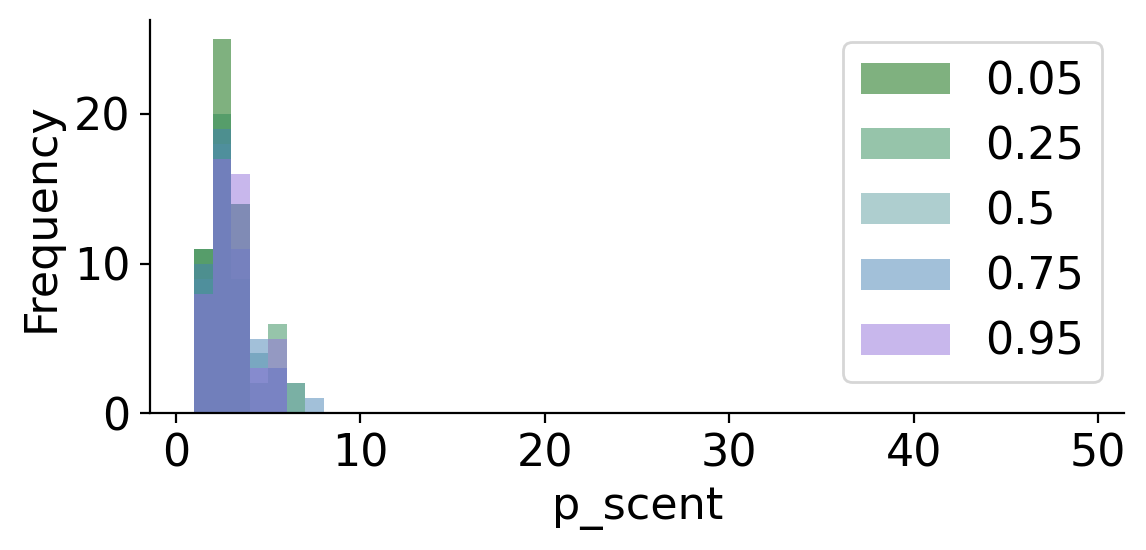

In [24]:
# Score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(6, 3))
plt.bar([str(n) for n in names], m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Avg. score")
plt.xlabel("p_scent")
plt.tight_layout()
sns.despine()

# Dists of means
fig = plt.figure(figsize=(6, 3))
for (i, s, c) in zip(names, scores, colors):
    plt.hist(s, label=i, color=c, alpha=0.5, bins=list(range(1,50,1)))
    plt.legend()
    plt.ylabel("Frequency")
    plt.xlabel("p_scent")
    plt.tight_layout()
    sns.despine()

### Question 2.1

How does increasing *p_scent* impact our Info agent's performance? Explain why this particular pattern emerges in the results.

In [25]:
# Write your answer here as a comment. Explain yourself.

### Question 2.2

Re-run the simulations from this section, but now change the drift-rate from 1.0 to 0.75. How and why does this influence the agent's behavior (compared to the higher drift-rate)?

In [26]:
# Write your answer here as a comment. Explain yourself.

### Question 2.3

Now set the drift-rate back to 1.0 and reduce the boundary height from 3.0 to 1.5. Re-run the simulations in again. How and why does this influence the agent's behavior (compared to the higher boundary height)?

In [27]:
# Write your answer here as a comment. Explain yourself.